In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchtext.vocab import Vectors, build_vocab_from_iterator

from utils.dataset import TabularDataset
from utils.tokenizer import MeCabTokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = TabularDataset("../data/dark_train.tsv")
test_dataset = TabularDataset("../data/dark_test.tsv")

In [4]:
tokenizer = MeCabTokenizer()

In [5]:
vocab = build_vocab_from_iterator(
    [tokenizer.tokenize(text) for text in train_dataset.texts],
    min_freq=10,
    specials=["<unk>", "<pad>"],
)
vocab.set_default_index(vocab["<unk>"])

In [6]:
def collate_batch(batch):
    text_list = [torch.tensor(vocab(tokenizer.tokenize(text))) for text, _ in batch]
    label_list = [label for _, label in batch]
    text_list = pad_sequence(text_list, padding_value=vocab["<pad>"])
    label_list = torch.tensor(label_list, dtype=torch.float)
    return text_list.to(device), label_list.to(device)

In [7]:
batch_size = 64

weights = [1 / (train_dataset.labels == label).sum() for label in train_dataset.labels]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights))

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

In [8]:
class LSTM(nn.Module):
    def __init__(self, vectors):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(vectors)
        self.lstm = nn.LSTM(200, 64, num_layers=2, bidirectional=True)
        self.linear = nn.Linear(64 * 2, 1)

    def forward(self, text):
        output = self.embedding(text)
        output, (hn, cn) = self.lstm(output)
        output = torch.cat([hn[-2], hn[-1]], dim=1)
        output = self.linear(output)
        output = torch.sigmoid(output)
        return output.squeeze()

In [9]:
japanese_word2vec_vectors = Vectors(name="../data/japanese_word2vec_vectors.vec")
vectors = japanese_word2vec_vectors.get_vecs_by_tokens(vocab.get_itos())

model = LSTM(vectors).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [10]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for text, label in dataloader:
        output = model(text)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.round().int()
        acc = (pred == label).sum() / len(pred)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}", end=" ")
    print(f"| train | Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}")
    if train_acc > 0.8:
        break

Epoch 1/10 | train | Loss: 0.6912 Accuracy: 0.5524
Epoch 2/10 | train | Loss: 0.6785 Accuracy: 0.6488
Epoch 3/10 | train | Loss: 0.5913 Accuracy: 0.7138
Epoch 4/10 | train | Loss: 0.5184 Accuracy: 0.7713
Epoch 5/10 | train | Loss: 0.4773 Accuracy: 0.7992
Epoch 6/10 | train | Loss: 0.4525 Accuracy: 0.8137


In [12]:
model.eval()
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for text, label in test_dataloader:
        output = model(text)
        y_true += label.tolist()
        y_pred += output.round().int().tolist()
        y_score += output.tolist()

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90      8536
         1.0       0.03      0.45      0.06       104

    accuracy                           0.82      8640
   macro avg       0.51      0.64      0.48      8640
weighted avg       0.98      0.82      0.89      8640



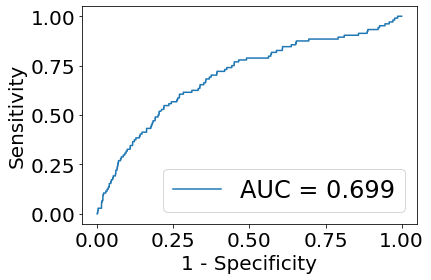

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.rcParams["font.size"] = 20
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.legend(loc="lower right", fontsize=24)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
# plt.savefig("roc_curve.pdf", bbox_inches="tight")
# torch.save(model.state_dict(), 'model_dark.pt')
plt.show()

In [15]:
import pandas as pd

pd.set_option("display.max_rows", None)

df = pd.read_csv("../data/dark_test.tsv", sep="\t")
df["Predicted"] = y_pred
df.query("Label == Predicted == 1")

,Sentence,Writer_Joy,Reader1_Joy,Reader2_Joy,Reader3_Joy,Avg. Readers_Joy,Readers_mean,Readers_std,Difference,Label,Predicted
4,THE W 今年が1番のめり込んで見たかもみんな頑張れ！みんな売れろ！って思っちゃう,1,3,3,2,3,2.666667,0.57735,-1.666667,1,1
56,しかもTBSチャンネル2で、ウルトラマンティガ一挙再放送… 最終回3部作の前の「ウルトラの星...,0,2,3,2,2,2.333333,0.57735,-2.333333,1,1
262,初めての都内運転でしたが実家から貰ったお守りと雛ちゃんのおかげで無事終わりました♪,0,1,1,2,1,1.333333,0.57735,-1.333333,1,1
505,クリスのドラム配置好き,0,1,1,2,1,1.333333,0.57735,-1.333333,1,1
516,イチロー超絶かっこええな,1,3,2,2,2,2.333333,0.57735,-1.333333,1,1
731,チャイティーラテと抹茶ラテだいすきおばさん,1,3,2,2,2,2.333333,0.57735,-1.333333,1,1
1369,福原愛さんおめでとうございます！！！,1,3,3,2,3,2.666667,0.57735,-1.666667,1,1
1465,星野源さんの「Soul」という曲、歌うと実に気持ちが良い。BPMとかよく知らんけど聞いていて...,1,3,2,2,2,2.333333,0.57735,-1.333333,1,1
1639,YMOにハマりたての頃は、その音楽の素晴らしさに感銘受け過ぎて、細野さんの画像ばかり集めてか...,1,3,2,3,3,2.666667,0.57735,-1.666667,1,1
1820,今日は約10時間くらい本を書いてました！疲れたけど、モノ作り楽しいです(≧∇≦)/読者の方々...,1,2,3,2,2,2.333333,0.57735,-1.333333,1,1
